<a href="https://colab.research.google.com/github/fuanonemus/cop4630spring2020/blob/master/HW4_4630_part3b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

this is a copy of https://colab.research.google.com/drive/1F-RWvoxH8MmT7c1UmNy41iuOp-ejiLoF edited for hw4 problem 3. In this part, I continued the use of MobileNet, and I fine tuned the same three layers: conv_pw_7, conv_dw_10, and conv_dw_2_relu. The difference in this version is that I used tanh and linear as activation functions in the dense layers instead of softmax and exponential. The model behaved much more poorly in this iteration, and I think its because the tanh activation led to more variation in the data and linear lead the model to resist the behavior of the data as well.

# Fine-tuning VGG16 

This is based on section 5.3 *Using a pretrained convnet* of the book *Deep learning with Python* by Francois Chollet. I have made several changes to the code. I use the data that is already provided by Google. I don't download the data from Kaggle as in the deep learning book.

## Feature extraction

Feature extraction consists of using the representations learned by a previous network to extract interesting features from new samples. These features are then run through a new classifier, which is trained from scratch.

We will use here the convolutional base of the VGG16 model to extract the features. We will feed these features to a densely connected classifier with dropout. We will fine-tune some layers.

## Download the data

Download the example data, a zip. of 2,000 JPG pictures of cats and dogs and extract it locally in ```/tmp```.



In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2020-04-21 23:38:21--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.11.176, 2607:f8b0:4007:803::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.11.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   187MB/s    in 0.3s    

2020-04-21 23:38:22 (187 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Note that the data provided by Google does not have a test set.

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Build network with VGG16 convolution base and custom densely connected layers

### Load the convolutional base

In [4]:
from keras.applications import MobileNet

conv_base = MobileNet(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


17227776/17225924 [==============================] - 1s 0us/step


### Freeze the convolutional base

In [0]:
conv_base.trainable = False

### Concatenate the convolutional base and densely connected layers

In [0]:
from keras import layers
from keras import models
from keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(64, activation='linear'))
#model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation='sigmoid'))

In [7]:
model.summary()
conv_base.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_1 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               4194560   
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 7,464,641
Trainable params: 4,235,777
Non-trainable params: 3,228,864
____________________________________

## Train the model end to end with frozen convolutional base

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

# compile model

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizers.RMSprop(lr=2e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 27s 266ms/step - loss: 0.4116 - acc: 0.8150 - val_loss: 0.3429 - val_acc: 0.9490
Epoch 2/30
100/100 [==============================] - 19s 187ms/step - loss: 0.2904 - acc: 0.8730 - val_loss: 0.2857 - val_acc: 0.9530
Epoch 3/30
100/100 [==============================] - 19s 185ms/step - loss: 0.2671 - acc: 0.8875 - val_loss: 0.1540 - val_acc: 0.9550
Epoch 4/30
100/100 [==============================] - 18s 184ms/step - loss: 0.2425 - acc: 0.8960 - val_loss: 0.0046 - val_acc: 0.9560
Epoch 5/30
100/100 [==============================] - 18s 183ms/step - loss: 0.2238 - acc: 0.9035 - val_loss: 0.0138 - val_acc: 0.9580
Epoch 6/30
100/100 [==============================] - 18s 183ms/step - loss: 0.2098 - acc: 0.9140 - val_loss: 0.0042 - val_acc: 0.9570
Epoch 7/30
100/100 [==============================] - 18s 182ms/step - loss: 0.2194 - acc: 0.9020 - val_lo

## Display curves of loss and accuracy during training

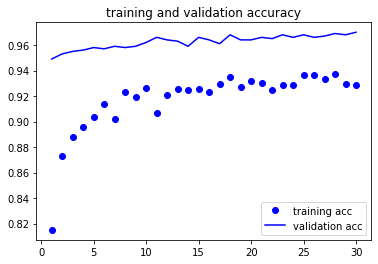

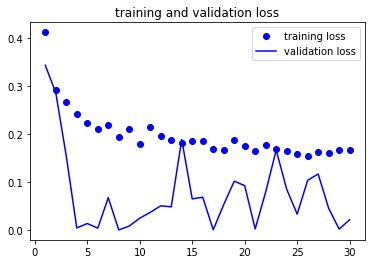

In [11]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [0]:
conv_base.trainable = True

for layer in conv_base.layers:
  if layer.name == 'conv_pw_7' or layer.name == 'conv_dw_10' or layer.name == 'conv_dw_2_relu':
    layer.trainable = True
  else:
    layer.trainabletrainable = False

In [14]:
# compile model

model.compile(
    loss='binary_crossentropy',
    #
    # choose a smaller learning rate
    #
    optimizer=optimizers.RMSprop(lr=1e-5), 
    metrics=['acc'])

# train

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 30s 297ms/step - loss: 0.1668 - acc: 0.9365 - val_loss: 0.1941 - val_acc: 0.9660
Epoch 2/100
100/100 [==============================] - 24s 235ms/step - loss: 0.1777 - acc: 0.9250 - val_loss: 0.0902 - val_acc: 0.9670
Epoch 3/100
100/100 [==============================] - 23s 234ms/step - loss: 0.1463 - acc: 0.9440 - val_loss: 0.1162 - val_acc: 0.9590
Epoch 4/100
100/100 [==============================] - 23s 234ms/step - loss: 0.1472 - acc: 0.9430 - val_loss: 0.0152 - val_acc: 0.9680
Epoch 5/100
100/100 [==============================] - 23s 235ms/step - loss: 0.1369 - acc: 0.9520 - val_loss: 0.0670 - val_acc: 0.9570
Epoch 6/100
100/100 [==============================] - 24s 237ms/step - loss: 0.1342 - acc: 0.9455 - val_loss: 0.1472 - val_acc: 0.9560
Epoch 7/100
100/100 [==============================] - 24s 237ms/step - loss: 0.0988 - acc: 0.9615 - val_loss: 0.0603 - val_acc: 0.9570
Epoch 8/100
100/100 [===========================

## Display learning curves during fine-tuning

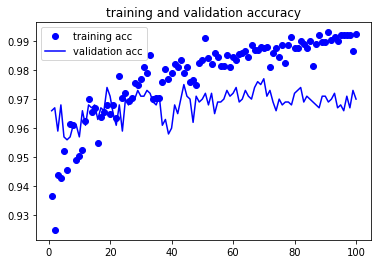

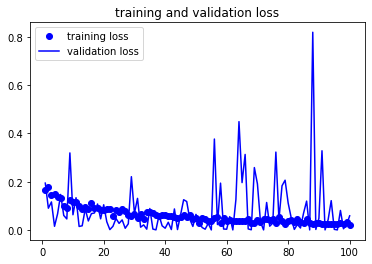

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# training and validation accuracy

plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.legend()

plt.figure()

# training and validation loss

plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.legend()

plt.show()

This looks like overfitting. I should try  adding dropout for the densely connected layer.

## Print out validation loss and accuracy

In [0]:
val_loss, val_acc = model.evaluate_generator(validation_generator, steps=50)

In [17]:
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

Validation loss: 0.05859150364995003
Validation accuracy: 0.9700000286102295


## Save the model

In [0]:
model_fname = 'cats_and_dogs_small_4.h5' 
model.save(model_fname)

In [0]:
from google.colab import files

with open(model_fname, 'r') as f:
  files.download(model_fname)